# Rapport final Segmentation : Mumford-Shah problem

**Jmal Yessine, Kallel Ismail, Taieb Talel, Vouters Sébastien**

4ModIA : 2022-2023

Soutenance le 23 juin 2023

### The objectives of the two phase piecewise contstant Mumford-Shah problem is to segment images into two regions : foreground and background.

Let an image defined on the domain $\Omega \in \mathbb{R}^{2}$
A gray scaling $I(.)$ is applied to each image pixel; $I : \Omega \mapsto [0;255]$.
Then, we can calculate a binary mask to solve the binary segmentation problem  $u : \Omega \mapsto \{0;1\}$

Hence : 
* the foreground region $S_f = \{x \in \Omega , u(x) = 1 \}$
* the background region $S_b = \{x \in \Omega , u(x) = 0 \}$

This segmentation problem is a minimization problem :

$$ ( u^{*},c_{1}^{*},u_{2}^{*} ) = 
            \underset{ \substack{
            u \in \{0;1\}^{| \Omega |}\\
            c_1 \in [0;255]\\
            c_2 \in [0;255]}} {\operatorname{argmin}}
            \underbrace{\int_{\Omega} |Du|}_{\textit{foreground contour length}}
            + \lambda \underbrace{\int_{\Omega} |I(x) - c_1|^2 u(x) \,dx}_{\textit{color variation in foreground}}
            + \lambda \underbrace{\int_{\Omega} |I(x) - c_2|^2 (1-u(x)) \,dx}_{\textit{color variation in background}}
$$
$\lambda \geq 0$ weights the influence of the regularization term (the foreground contour length) with respect to the data term (color variations)

However, minimizing this problem with respect to $u$ within a variational framework is limited by two main technical issues :

* The binary mask $u$ lives in $\{0; 1\}^{|\Omega|}$ is **not a convex space**.
* The analytic derivation of the regularization term gives $div \big{(}\frac{\nabla u}{||\nabla u||}\big{)}$ which is **not defined everywhere and involves numerical approximations** (where $||\nabla u(x)|| = 0$) ; $L_1$ norms are non-differentiable at $x=0$.

Hence, we will study some approaches introduced in papers of A. Chambolle and T. Chan and their co-authors, allowing to compute $u$ within a variational framework.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.integrate import simpson
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from matplotlib import cm
import cv2 as cv
from PIL import Image
import mpl_toolkits.mplot3d.art3d as art3d
from skimage import measure
from functions import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


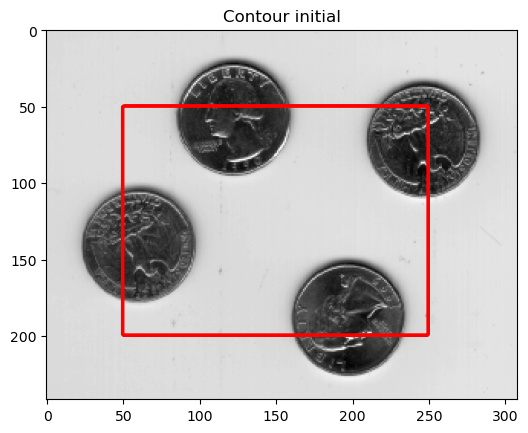

In [2]:
# Chargement de l'image
image = io.imread('eight.png')
image = image.astype(float)

# Masque initial
mask_initial = np.zeros_like(image)
mask_initial[50:200, 50:250] = 1

# Affichage
fig, ax = plt.subplots(1,1)
affichage(ax,image, mask_initial, 'Contour initial')
plt.show()

## Chan-Vese level set formulation

In order to solve the previous problems with $u$ convexity and regulation term derivative, we introduce a surface $\Phi : x \in \Omega \mapsto \mathbb{R}$ with an interesting property :

* $\phi(x)=0$ represents the mask contour
* $\phi(x)>0$ represents the foreground
* $\phi(x)<0$ represents the background

Thus, we have a link between the mask $u$ ans $\phi$ : $u(x)=H_{\eta}(\phi(x))$ with
$$H_{\eta} = \frac{1}{2} + \frac{arctan\big{(}\frac{\phi(x)}{\eta}\big{)}}{\pi}$$

We have
$$\int_{\Omega} |Du| = \int_{\Omega} \lVert \nabla H_{\eta}(\phi(x)) \lVert dx = \int_{\Omega} H_{\eta}'(\phi(x)) \lVert \nabla \phi(x) \lVert_{\epsilon} dx$$

and we use a regularization term $\epsilon \in ]0,1]$ such that :
$$\lVert \nabla \phi(x) \lVert_{\epsilon} =  \sqrt{\phi^2_x(x) + \phi^2_y(x) + \epsilon^2}$$

Now we have a calculable optimization problem.

Here is the initial $\phi$ function according to our initial mask, the mask borders are represented where $\phi(x)=0$

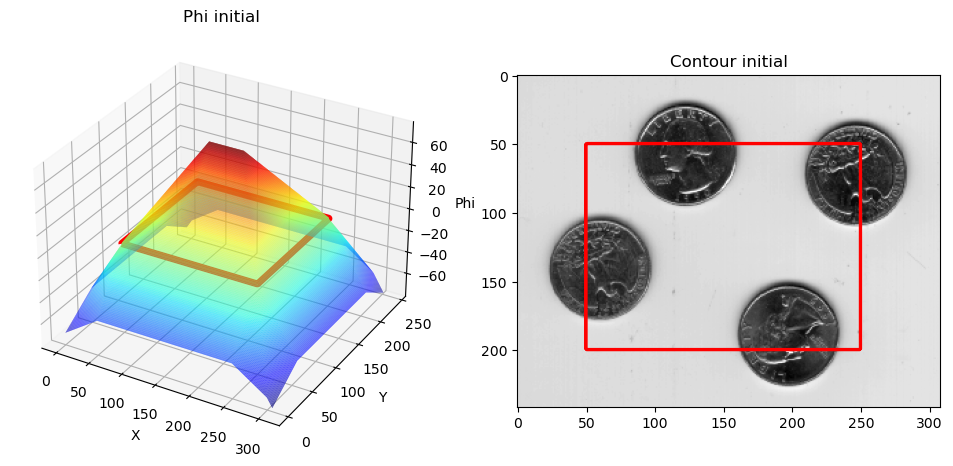

In [3]:
phi_initial = signed_distance_from_mask(mask_initial)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

visualize_phi(ax1, phi_initial, 'Phi initial')
affichage(ax2, image, mask_initial, 'Contour initial')
plt.show()

The algorithm structure is : 

While : $\lVert H_{\eta}(\phi^{k+1}) - H_{\eta}(\phi^{k})\rVert > Threshold$
   * Update colors $c_1^{k+1}$ and $c_2^{k+1}$ (intensity mean in foreground/background regions)
   * Update H($\phi^{k+1}$) with
$$ 
\phi^{k+1} = \phi^k + \tau H'_{\eta}(\phi^k)\Big{[}\mathop{\rm div} \big{(}\frac{\nabla \phi^k}{\lVert \nabla \phi^k(x) \rVert_{\epsilon}}\big{)} - \lambda\big{(}I - c_1^{k+1}\big{)}^2 - \lambda \big{(}I - c_2^{k+1}\big{)}^2\Big{]}
$$
   * Evrey n iterations, we update $\phi^{k+1}$ using the H function (converting to mask and converting back to $\phi$ again)

In [4]:
# Parametres
eta = 1.0
epsilon = 1.0
lambda_val = 1
threshold=0.2
n_iterations = 800

In [5]:
phi,phi_sequence, functional = Chan_Vese_level_set_formulation(image, phi_initial, eta, epsilon, lambda_val, n_iterations, threshold=threshold) 

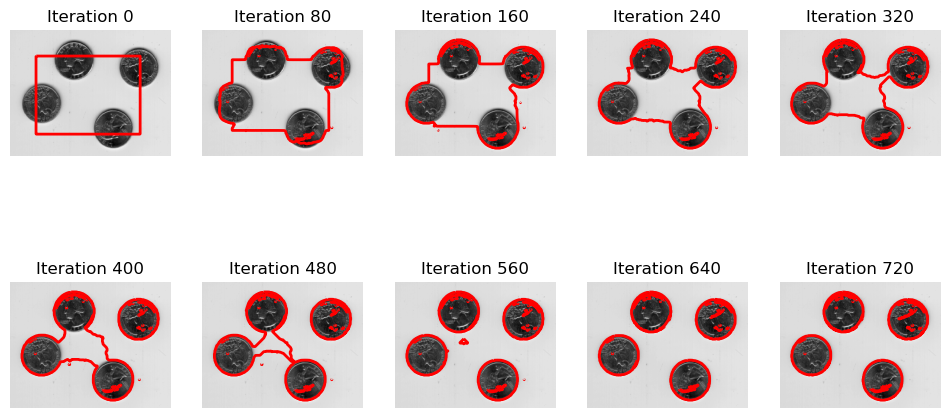

In [6]:
phi_sequence, indices = extract_elements(phi_sequence)

# Affichage de l'evolution du masque
plt.figure(figsize=(12, 6))
for i, phi in enumerate(phi_sequence):
    
    plt.subplot((len(phi_sequence)+4)//5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Iteration {}'.format(indices[i]))
    plt.axis('off')

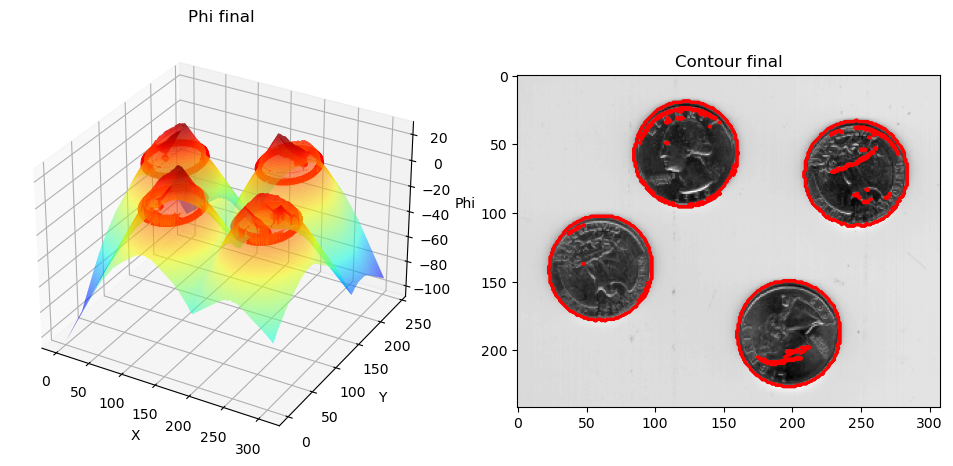

In [8]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

visualize_phi(ax1, phi, 'Phi final')
affichage(ax2, image, phi_to_mask(phi), 'Contour final')
plt.show()

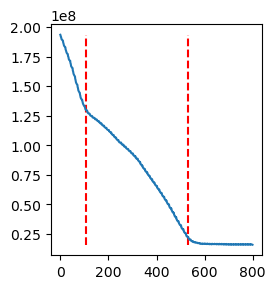

In [23]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax.plot(functional)
ax.vlines(x=[105,530], ymin=min(functional), ymax=max(functional), color='red', linestyles='dashed')

We can see 3 phases : 
* Phase 1 : the mask extends towards coins contour
* Phase 2 : the mask shrinks towards coins contour
* Phase 3 : the mask has the shape of the coins

### Study of regularization parameter $\lambda$ influence with 1000 iterations

In [37]:
eta = 1
epsilon = 1.0
lambda_val = [10e-6, 10e-5, 10e-4, 10e-3, 10e-2]
threshold=10e-10
n_iterations = 1000

In [38]:
phi_list = []
for lambd in lambda_val :
    phi,_,_ = Chan_Vese_level_set_formulation(image, phi_initial, eta, epsilon, lambd, n_iterations, threshold=threshold) 
    phi_list.append(phi)

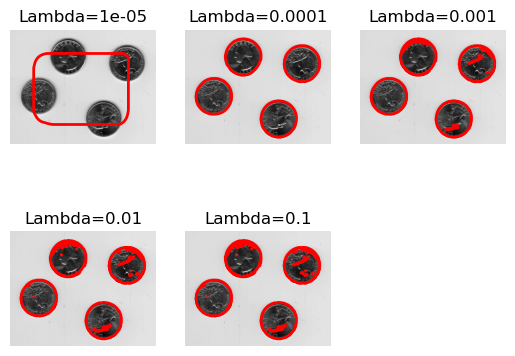

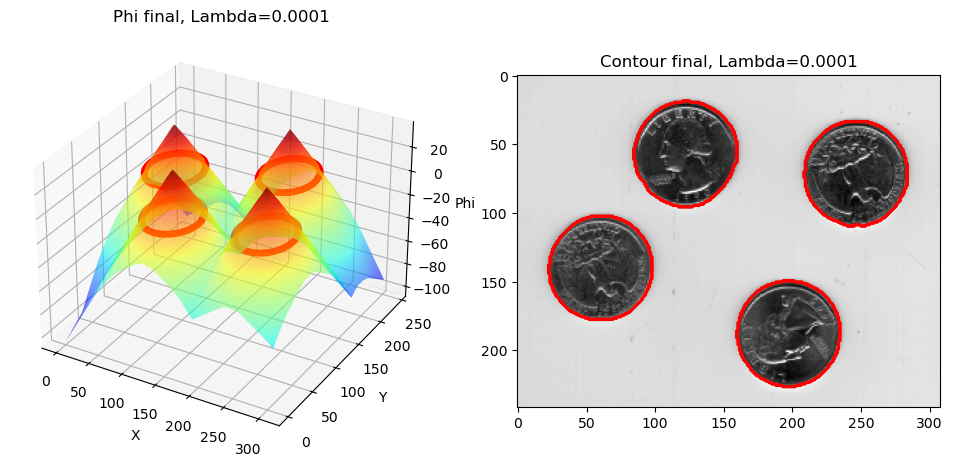

In [39]:
for i, phi in enumerate(phi_list) :
    plt.subplot((len(phi_list)+2)//3, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Lambda={}'.format(lambda_val[i]))
    plt.axis('off')

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

visualize_phi(ax1, phi_list[1], 'Phi final, Lambda={}'.format(lambda_val[1]))
affichage(ax2, image, phi_to_mask(phi_list[1]), 'Contour final, Lambda={}'.format(lambda_val[1]))
plt.show()

In our case, the best regularization parameter $\lambda$ seems to be 0.0001. To small values reduce the ability of the algorithm to adapt to the coins' shape and to large values give high details (the algorithm adapts to every shapes no matter how small they are).

### Study of approximation parameter of Heaviside function $\eta$ with 200 iterations

In [49]:
eta_list = [100, 10, 5, 2, 1, 0.1]
epsilon = 1.0
lambda_val = 1e-4
threshold = 10e-10
n_iterations = 200

In [50]:
phi_list = []
functional = []
for eta in eta_list :
    phi,_,func = Chan_Vese_level_set_formulation(image, phi_initial, eta, epsilon, lambd, n_iterations, threshold=threshold) 
    phi_list.append(phi)
    functional.append(func)

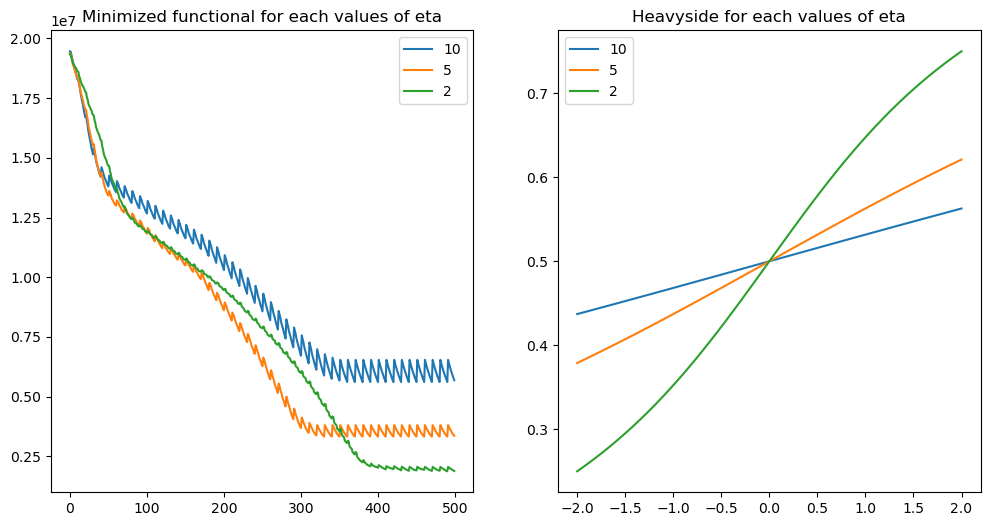

In [60]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, eta in enumerate(eta_list) :
    ax1.plot(functional[i], label=str(eta))
    ax1.legend()
    ax1.set_title('Minimized functional for each values of eta')
    x = np.linspace(-2,2,num=50)
    ax2.plot(x,heavyside_eta(x, eta), label=str(eta))
    ax2.legend()
    ax2.set_title('Heavyside for each values of eta')

We can see that, for 200 iterations, the best value of $\eta$ seems to be 5. For this value, the functional seems to converge quicker to its minimum.

In [54]:
eta_list = [10, 5, 2]
epsilon = 1.0
lambda_val = 1e-4
threshold = 0.3
n_iterations = 500

In [55]:
phi_list = []
functional = []
for eta in eta_list :
    phi,_,func = Chan_Vese_level_set_formulation(image, phi_initial, eta, epsilon, lambd, n_iterations, threshold=threshold) 
    phi_list.append(phi)
    functional.append(func)

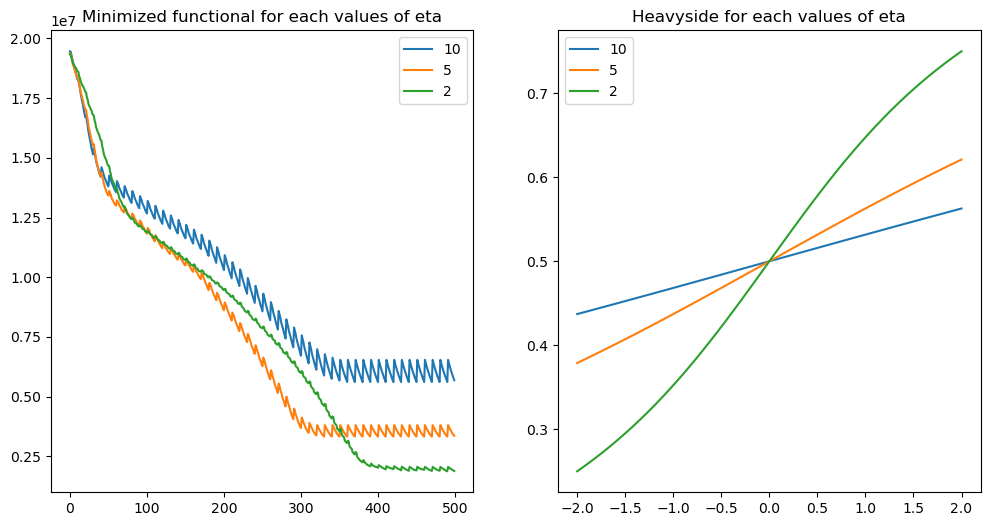

In [62]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, eta in enumerate(eta_list) :
    ax1.plot(functional[i], label=str(eta))
    ax1.legend()
    ax1.set_title('Minimized functional for each values of eta')
    x = np.linspace(-2,2,num=50)
    ax2.plot(x,heavyside_eta(x, eta), label=str(eta))
    ax2.legend()
    ax2.set_title('Heavyside for each values of eta')

We can see that, for 200 iterations, the best value of $\eta$ seems to be 2. For this value, the functional seems to converge to a better minimum. It looks like a good compromise between conserving Heavyside shape and improving its continuity.

### Study of norm regularization parameter $\epsilon$ with 200 iterations

In [95]:
eta = 2.0
epsilon_list = [100.0, 1.0, 1e-4]
lambda_val = 1e-4
threshold = 0.3
n_iterations = 200

In [96]:
phi_list = []
functional = []
for epsilon in epsilon_list :
    phi,_,func = Chan_Vese_level_set_formulation(image, phi_initial, eta, epsilon, lambd, n_iterations, threshold=threshold) 
    functional.append(func)
    phi_list.append(phi)

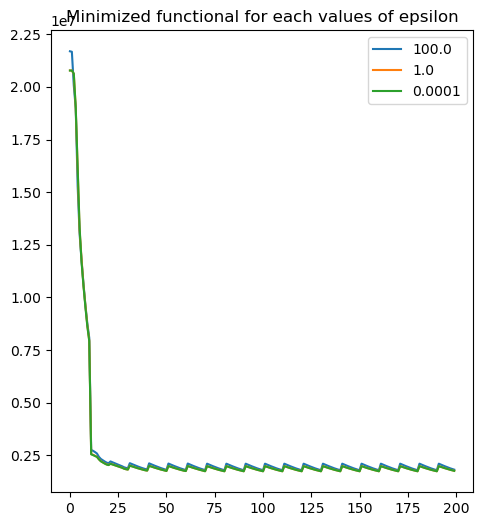

In [97]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)

for i, epsilon in enumerate(epsilon_list) :
    ax1.plot(functional[i], label=str(epsilon))
    ax1.legend()
    ax1.set_title('Minimized functional for each values of epsilon')

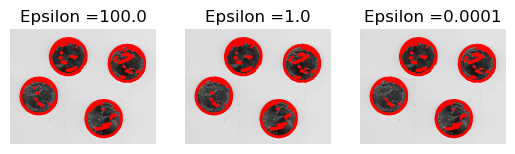

In [98]:
for i, phi in enumerate(phi_list) :
    plt.subplot(2, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Epsilon ={}'.format(epsilon_list[i]))
    plt.axis('off')

This parameter does not seem to have a lot of influence on results.

### Study of initial mask $u$ influence with 300 iterations

In [104]:
mask_zeros = np.zeros_like(image)
mask_ones = np.ones_like(image)

mask_one_piece = np.zeros_like(image)
mask_one_piece[150:250,150:250] = 1

mask_two_pieces = np.zeros_like(image)
mask_two_pieces[1:200,200:] = 1

mask_random = np.random.randint(2, size=image.shape)

mask_initial = np.zeros_like(image)
mask_initial[50:200, 50:250] = 1

In [105]:
phi_zeros = signed_distance_from_mask(mask_zeros)
phi_ones = signed_distance_from_mask(mask_ones)

phi_one_piece = signed_distance_from_mask(mask_one_piece)
phi_two_pieces = signed_distance_from_mask(mask_two_pieces)

phi_random = signed_distance_from_mask(mask_random)

phi_initial = signed_distance_from_mask(mask_initial)

In [106]:
eta = 5.0
epsilon = 1.0
lambda_val = 1e-4
threshold = 0.3
n_iterations = 200

phis = [phi_zeros, phi_ones, phi_one_piece, phi_two_pieces, phi_random, phi_initial]
names = ['zeros', 'ones', 'one piece', 'two pieces', 'random', 'initial']

/tmp/ipykernel_71387/1312657878.py:4: UserWarning: No contour levels were found within the data range.
  plt.contour(phi, levels=[0], colors='r', linewidths=2)


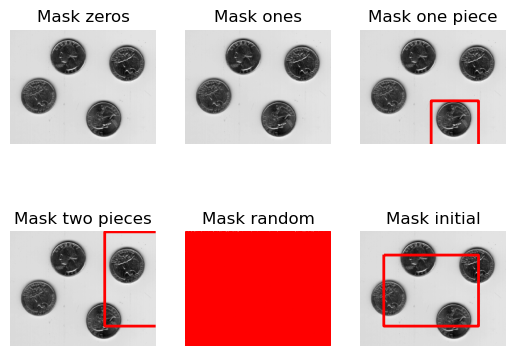

In [107]:
for i, phi in enumerate(phis) :
    plt.subplot(2, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Mask {}'.format(names[i]))
    plt.axis('off')

In [ ]:
phi_list = []
functional = []
for phi_initial in phis :
    phi,_,func = Chan_Vese_level_set_formulation(image, phi_initial, eta, epsilon, lambd, n_iterations, threshold=threshold) 
    phi_list.append(phi)
    functional.append(func)

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)

for i, name in enumerate(names) :
    ax1.plot(functional[i], label=name)
    ax1.legend()
    ax1.set_title('Minimized functional for each initial masks')

In [ ]:
for i, phi in enumerate(phi_list) :
    plt.subplot((len(phi_list)+2)//3, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Mask {}'.format(names[i]))
    plt.axis('off')

Initial mask has a big impact : it needs to be well initialized to allow the algorithm to converge to a convenient solution.

### FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)

In [14]:
eta = 2.0
epsilon = 1.0
lambda_val = 1e-4
threshold = 0.4
n_iterations = 300

phi,phi_sequence = Chan_Vese_level_set_fista_formulation(image, phi_initial, eta, epsilon, lambda_val, n_iterations, threshold=threshold) 

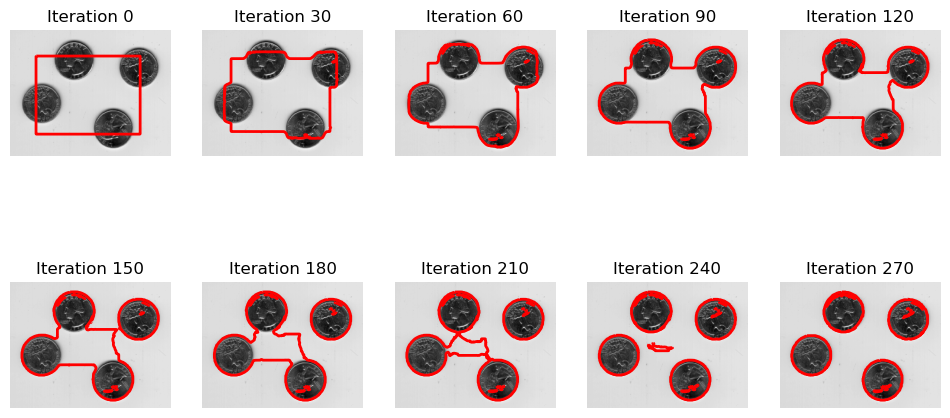

In [15]:
phi_sequence, indices = extract_elements(phi_sequence)

# Affichage de l'evolution du masque
plt.figure(figsize=(12, 6))
for i, phi in enumerate(phi_sequence):
    
    plt.subplot((len(phi_sequence)+4)//5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Iteration {}'.format(indices[i]))
    plt.axis('off')

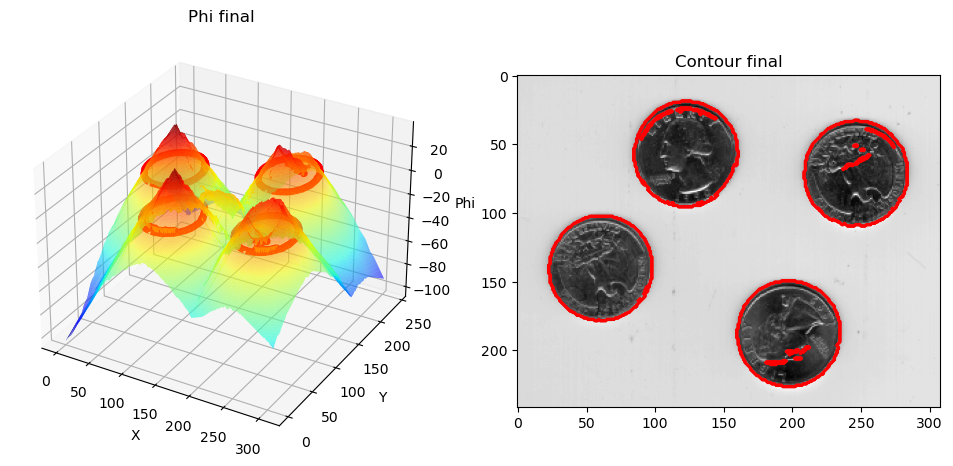

In [16]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

visualize_phi(ax1, phi, 'Phi final')
affichage(ax2, image, phi_to_mask(phi), 'Contour final')
plt.show()

## Chan, Esedoglu and Nikolova convex formulation

In [17]:
tau = 0.01
c1 = 110.
c2 = 227.
lamb = 10e-5
nb_iter = 100
threshold = 0.5

In [18]:
mask, functional = projected_gradient(mask_initial, image, tau, lamb, c1, c2, nb_iter, threshold)

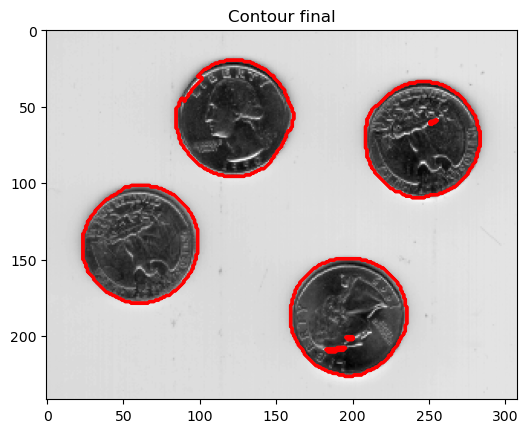

In [19]:
fig, ax = plt.subplots(1,1)
affichage(ax, image, mask, 'Contour final')
plt.show()

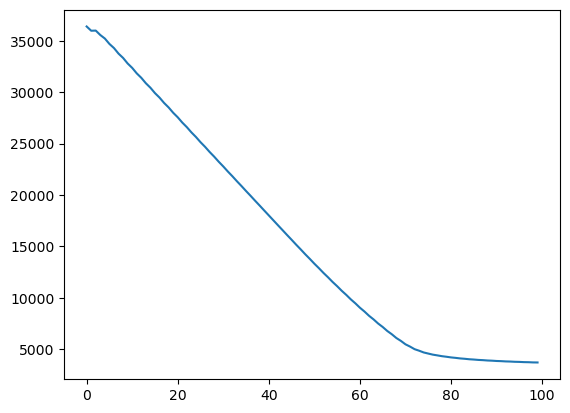

In [20]:
plt.plot(functional)

## Dual Formulation of the Total Variation

In [21]:
tau = 1/4
sigma = 1/2
c1 = 110
c2 = 227
lamb = 1e-4
nb_iter = 100
threshold = 1e-3
eps = 1
z0 = np.array([gradx(mask_initial), grady(mask_initial)])

In [22]:
u = test_dual(mask_initial, z0, image, tau, sigma, lamb, c1, c2, nb_iter, eps, threshold)

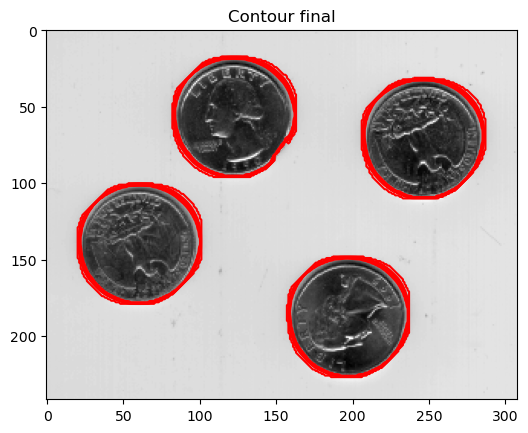

In [23]:
fig, ax = plt.subplots(1,1)
affichage(ax, image, u, 'Contour final')
plt.show()

## Conclusion
It is interesting to see how resolving the issues results in algorithms which are more accurate, faster, more stable and simpler to parameterize.

Note that such problem can also be solved by graph cuts or by propagation algorithms

## References